In [185]:
chrom = '20'
family_sizes = [3, 4, 5, 6, 7]
phase_dir = '../sherlock_phased'
data_dir = '../split_gen_miss'

In [186]:
# Pull cytogenetic coordinates
with open('../data/cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])

In [187]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [188]:
from collections import Counter

# sample_ids
sample_ids = []
father_ids = set()
mother_ids = set()
individual_to_family = dict()
family_to_individuals = dict()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf:
        next(famf) # skip header
        for line in famf:
            pieces = line.strip().split('\t')
            individuals = pieces[1:(1+j)]
            mother_ids.add(individuals[0])
            father_ids.add(individuals[1])
            sample_ids.extend(individuals)
            family_to_individuals[pieces[0]] = individuals
            for ind in individuals:
                individual_to_family[ind] = pieces[0]
            
# Remove individuals from multiple families
appearances = Counter(sample_ids)
print('Removing individuals in multiple families', len([k for k, v in appearances.items() if v>1]))
sample_ids = [x for x in sample_ids if appearances[x] == 1]

# map sample ids to index
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])
parent_indices = [i for i, x in enumerate(sample_ids) if x in mother_ids or x in father_ids]
father_indices = [i for i, x in enumerate(sample_ids) if x in father_ids]
mother_indices = [i for i, x in enumerate(sample_ids) if x in mother_ids]

child_indices = [i for i, x in enumerate(sample_ids) if x not in mother_ids and x not in father_ids]
affected_indices = [i for i, x in enumerate(sample_ids) if child_id_to_affected[x] == '2' and i in set(child_indices)]
unaffected_indices = [i for i, x in enumerate(sample_ids) if child_id_to_affected[x] != '2' and i in set(child_indices)]
male_affected_indices = [i for i, x in enumerate(sample_ids) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and i in set(child_indices)]
male_unaffected_indices = [i for i, x in enumerate(sample_ids) if child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'  and i in set(child_indices)]
female_affected_indices = [i for i, x in enumerate(sample_ids) if child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'  and i in set(child_indices)]
female_unaffected_indices = [i for i, x in enumerate(sample_ids) if child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1' and i in set(child_indices)]

m = len(sample_id_to_index)
print('m', m, 'parents', len(parent_indices), 'children', len(child_indices))
print('mother ids', len(mother_ids), 'father ids', len(father_ids), len(mother_ids & father_ids))

Removing individuals in multiple families 9
m 3929 parents 1727 children 2202
mother ids 866 father ids 870 0


In [254]:
from collections import defaultdict
import numpy as np

all_snp_positions = []
all_x_alleles = []
all_x_bin = []

for chrom in range(20, 21):
    print(chrom)
    # use only "cleaned" variants - must be SNPs and missingness in parents can't be sex-biased
    snp_indices = []
    snp_positions = []
    clean_file = '%s/clean_indices_%s.txt' % (data_dir, chrom) 
    with open(clean_file, 'r') as f:
        for i, line in enumerate(f):
            index, position = line.strip().split('\t')
            snp_indices.append(int(index))
            snp_positions.append(int(position))
    snp_positions = np.array(snp_positions)
    pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])
    n = snp_positions.shape[0]

    # load deletions
    deletions = np.zeros((m, n), dtype=np.int8)-1
    bin_deletions = np.zeros((m, n, 2), dtype=np.int8)
    
    for j in family_sizes:
        with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf, \
        open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
            next(famf) # skip header
            next(phasef) # skip header

            fam_pieces = (None,)

            for line in phasef:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                state = list(map(int, pieces[1:(1+(j*2))]))
                start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
                start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]

                # make sure we're on the right family
                while family_key != fam_pieces[0]:
                    fam_pieces = next(famf).strip().split('\t')
                    fam_individuals = fam_pieces[1:(1+j)]

                if fam_individuals[0] in sample_id_to_index:
                    if state[0] != -1 and state[1] != -1:
                        deletions[sample_id_to_index[fam_individuals[0]], start_index:(end_index+1)] = sum(state[:2])
                    if state[0] == 0 or state[1] == 0:
                        bin_deletions[sample_id_to_index[fam_individuals[0]], start_index:(end_index+1), 0] = 1
                    if state[0] == 1 or state[1] == 1:
                        bin_deletions[sample_id_to_index[fam_individuals[0]], start_index:(end_index+1), 1] = 1
                        
                if fam_individuals[1] in sample_id_to_index:
                    if state[2] != -1 and state[3] != -1:
                        deletions[sample_id_to_index[fam_individuals[1]], start_index:(end_index+1)] = sum(state[2:4])
                    if state[2] == 0 or state[3] == 0:
                        bin_deletions[sample_id_to_index[fam_individuals[1]], start_index:(end_index+1), 0] = 1
                    if state[2] == 1 or state[3] == 1:
                        bin_deletions[sample_id_to_index[fam_individuals[1]], start_index:(end_index+1), 1] = 1
                        
                for k, child_id in enumerate(fam_individuals[2:]):
                    mat, pat = state[(4+(2*k)):(6+(2*k))]

                    if child_id in sample_id_to_index:
                        if (mat != -1) and (pat != -1) and (state[mat] != -1) and (state[2+pat] != -1):
                            deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (state[mat]+state[2+pat])
                        if (mat == -1) and (pat != -1) and (state[0] == state[1]) and (state[0] != -1) and (state[2+pat] != -1):
                            deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (state[0]+state[2+pat])
                        if (mat != -1) and (pat == -1) and (state[mat] != -1) and (state[2] == state[3]) and (state[2] != -1):
                            deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (state[mat]+state[2])
                        if (mat == -1) and (pat == -1) and (state[0] == state[1]) and (state[0] != -1) and (state[2] == state[3]) and (state[2] != -1):
                            deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (state[0]+state[2])
                            
                        if (mat != -1 and state[mat] == 0) or (state[0] == state[1] and state[0] == 0):
                            bin_deletions[sample_id_to_index[child_id], start_index:(end_index+1), 0] = 1
                        elif (mat != -1 and state[mat] == 1) or (state[0] == state[1] and state[0] == 1):
                            bin_deletions[sample_id_to_index[child_id], start_index:(end_index+1), 1] = 1
                            
                        if (pat != -1 and state[2+pat] == 0) or (state[2] == state[3] and state[2] == 0):
                            bin_deletions[sample_id_to_index[child_id], start_index:(end_index+1), 0] = 1
                        elif (pat != -1 and state[2+pat] == 1) or (state[2] == state[3] and state[2] == 1):
                            bin_deletions[sample_id_to_index[child_id], start_index:(end_index+1), 1] = 1
    
    change_indices = np.where(np.any(bin_deletions[:, 1:, :] != bin_deletions[:, :-1, :], axis=0))[0]
    n = change_indices.shape[0]+1
    X_allele = np.zeros((m, n), dtype=np.int8)
    X_allele[np.where(deletions[:, change_indices]==1)] += 1 
    X_allele[np.where(deletions[:, change_indices]==2)] += 2
    X_allele[deletions[:, -1]==1, -1] += 1
    X_allele[deletions[:, -1]==2, -1] += 2
    
    X_bin = np.zeros((m, 2*n), dtype=np.int8)
    X_bin[np.where(bin_deletions[:, change_indices, 0]==1)] = 1
    x, y = np.where(bin_deletions[:, change_indices, 1]==1)
    X_bin[x, n+y] = 1
                        
    change_snp_positions = np.zeros((n, 2))
    change_snp_positions[0, 0] = snp_positions[0]
    change_snp_positions[1:, 0] = snp_positions[change_indices+1]
    change_snp_positions[:-1, 1] = snp_positions[change_indices]
    change_snp_positions[-1, 1] = snp_positions[-1]
    
    all_snp_positions.append(change_snp_positions)
    all_x_alleles.append(X_allele)
    all_x_bin.append(X_bin)


20


In [255]:
X_bin = np.hstack(all_x_bin)
X_allele = np.hstack(all_x_alleles)
snp_positions = np.vstack(all_snp_positions)
y = np.asarray([1 if child_id_to_affected[child_id] == '2' else 0 for child_id in sample_ids])

In [256]:
m, n = X_allele.shape
print(X_allele.shape, snp_positions.shape)

(3929, 11699) (11699, 2)


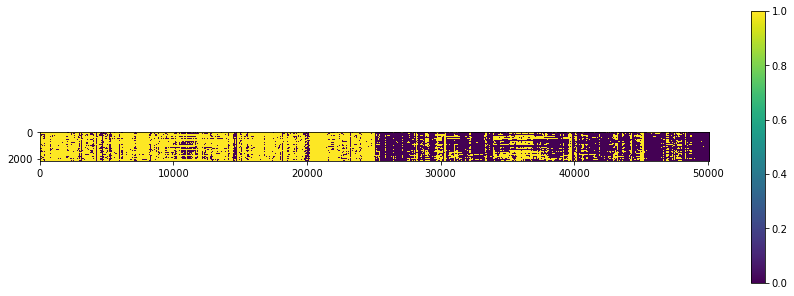

In [576]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.imshow(X_bin)
plt.colorbar()
plt.show()

In [61]:
X_allele_fused = np.zeros((m, n-1), dtype=np.int64)

s = np.sum(X_allele, axis=1)

X_allele_fused[:, 0] = s - n*X_allele[:, 0]
assert np.all(X_allele_fused[:, 0] == (s - n*X_allele[:, 0]))

for i in range(1, n-1):
    X_allele_fused[:, i] = X_allele_fused[:, i-1] + s - n*X_allele[:, i]
    
assert np.all(X_allele_fused[:, -1] == (-s + n*X_allele[:, -1]))

X_allele_fused = (1/n)*X_allele_fused
print(X_allele_fused)

[[ 0.00742485  0.01484971  0.02227456 ... -0.02227456 -0.01484971
  -0.00742485]
 [ 0.0507365   0.101473    0.15220949 ... -0.15220949 -0.101473
  -0.0507365 ]
 [ 0.41938446  0.83876891  1.25815337 ... -1.25815337 -0.83876891
  -0.41938446]
 ...
 [ 0.4315197   0.8630394   1.2945591  ... -1.2945591  -0.8630394
  -0.4315197 ]
 [ 0.51339268  1.02678536  1.54017804 ... -1.54017804 -1.02678536
  -0.51339268]
 [ 0.53690471  1.07380943  1.61071414 ... -1.61071414 -1.07380943
  -0.53690471]]


In [66]:
X_bin_fused = np.zeros((m, (2*n)-1), dtype=np.int64)

s = np.sum(X_bin, axis=1)

X_bin_fused[:, 0] = s - (2*n)*X_bin[:, 0]
assert np.all(X_bin_fused[:, 0] == (s - (2*n)*X_bin[:, 0]))

for i in range(1, (2*n)-1):
    X_bin_fused[:, i] = X_bin_fused[:, i-1] + s - (2*n)*X_bin[:, i]
    
assert np.all(X_bin_fused[:, -1] == (-s + (2*n)*X_bin[:, -1]))

X_bin_fused = (1/(2*n))*X_bin_fused
print(X_bin_fused)

[[-0.5301984  -1.06039679 -1.59059519 ... -1.40940481 -0.93960321
  -0.4698016 ]
 [-0.51247455 -1.0249491  -1.53742366 ... -1.46257634 -0.9750509
  -0.48752545]
 [-0.44529161 -0.89058321 -1.33587482 ... -1.66412518 -1.10941679
  -0.55470839]
 ...
 [-0.42938406 -0.85876811 -1.28815217 ... -1.71184783 -1.14123189
  -0.57061594]
 [-0.41716898 -0.83433795 -1.25150693 ... -1.74849307 -1.16566205
  -0.58283102]
 [-0.37559379 -0.75118758 -1.12678137 ... -1.87321863 -1.24881242
  -0.62440621]]


In [257]:
from sklearn.linear_model import LogisticRegression
import random

families = set(family_to_individuals.keys())
train_families = set(random.sample(families, int(len(families)*0.8)))
test_families = families - train_families

print('Train families', len(train_families), 'Test families', len(test_families))

train_individuals = set(sum([family_to_individuals[f] for f in train_families], []))
test_individuals = set(sum([family_to_individuals[f] for f in test_families], []))

train_indices = [i for i, x in enumerate(sample_ids) if (x in train_individuals) and (x not in mother_ids) and (x not in father_ids)]
test_indices = [i for i, x in enumerate(sample_ids) if (x in test_individuals) and (x not in mother_ids) and (x not in father_ids)]

mom_test_indices = [i for i, x in enumerate(sample_ids) if (x in test_individuals) and (x in mother_ids)]
dad_test_indices = [i for i, x in enumerate(sample_ids) if (x in test_individuals) and (x in father_ids)]

mom_train_indices = [i for i, x in enumerate(sample_ids) if (x in train_individuals) and (x in mother_ids)]
dad_train_indices = [i for i, x in enumerate(sample_ids) if (x in train_individuals) and (x in father_ids)]

parent_train_indices = mom_train_indices + dad_train_indices
parent_test_indices = mom_test_indices + dad_test_indices

print('Train', len(train_indices), 'Affected', np.sum(y[train_indices]==1)/len(train_indices), 'Unaffected', np.sum(y[train_indices]==0)/len(train_indices))
print('Test', len(test_indices), 'Affected', np.sum(y[test_indices]==1)/len(test_indices), 'Unaffected', np.sum(y[test_indices]==0)/len(test_indices))
print()

print('Mom Train', len(mom_train_indices), 'Affected', np.sum(y[mom_train_indices]==1)/len(mom_train_indices), 'Unaffected', np.sum(y[mom_train_indices]==0)/len(mom_train_indices))
print('Mom Test', len(mom_test_indices), 'Affected', np.sum(y[mom_test_indices]==1)/len(mom_test_indices), 'Unaffected', np.sum(y[mom_test_indices]==0)/len(mom_test_indices))

print('Dad Train', len(dad_train_indices), 'Affected', np.sum(y[dad_train_indices]==1)/len(dad_train_indices), 'Unaffected', np.sum(y[dad_train_indices]==0)/len(dad_train_indices))
print('Dad Test', len(dad_test_indices), 'Affected', np.sum(y[dad_test_indices]==1)/len(dad_test_indices), 'Unaffected', np.sum(y[dad_test_indices]==0)/len(dad_test_indices))


print('Parent train', len(parent_train_indices), 'Affected', np.sum(y[parent_train_indices]==1)/len(parent_train_indices), 'Unaffected', np.sum(y[parent_train_indices]==0)/len(parent_train_indices))
print('Parent test', len(parent_test_indices), 'Affected', np.sum(y[parent_test_indices]==1)/len(parent_test_indices), 'Unaffected', np.sum(y[parent_test_indices]==0)/len(parent_test_indices))

#model = LogisticRegression(penalty='l2', C=0.00001, fit_intercept=True, solver='lbfgs')
#model.fit(Xchild, y)

Train families 696 Test families 175
Train 1744 Affected 0.8268348623853211 Unaffected 0.1731651376146789
Test 458 Affected 0.8209606986899564 Unaffected 0.17903930131004367

Mom Train 684 Affected 0.0014619883040935672 Unaffected 0.9985380116959064
Mom Test 174 Affected 0.005747126436781609 Unaffected 0.9942528735632183
Dad Train 694 Affected 0.0 Unaffected 1.0
Dad Test 175 Affected 0.005714285714285714 Unaffected 0.9942857142857143
Parent train 1378 Affected 0.000725689404934688 Unaffected 0.9992743105950653
Parent test 349 Affected 0.0057306590257879654 Unaffected 0.994269340974212


In [258]:
male_train_indices = [i for i in train_indices if child_id_to_sex[sample_ids[i]]=='1']
female_train_indices = [i for i in train_indices if child_id_to_sex[sample_ids[i]]=='2']
male_test_indices = [i for i in test_indices if child_id_to_sex[sample_ids[i]]=='1']
female_test_indices = [i for i in test_indices if child_id_to_sex[sample_ids[i]]=='2']

print('Male Train', len(male_train_indices), 'Affected', np.sum(y[male_train_indices]==1)/len(male_train_indices), 'Unaffected', np.sum(y[male_train_indices]==0)/len(male_train_indices))
print('Male Test', len(male_test_indices), 'Affected', np.sum(y[male_test_indices]==1)/len(male_test_indices), 'Unaffected', np.sum(y[male_test_indices]==0)/len(male_test_indices))

print('Female Train', len(female_train_indices), 'Affected', np.sum(y[female_train_indices]==1)/len(female_train_indices), 'Unaffected', np.sum(y[female_train_indices]==0)/len(female_train_indices))
print('Female Test', len(female_test_indices), 'Affected', np.sum(y[female_test_indices]==1)/len(female_test_indices), 'Unaffected', np.sum(y[female_test_indices]==0)/len(female_test_indices))

Male Train 1268 Affected 0.8801261829652997 Unaffected 0.11987381703470032
Male Test 323 Affected 0.8885448916408669 Unaffected 0.11145510835913312
Female Train 476 Affected 0.6848739495798319 Unaffected 0.31512605042016806
Female Test 135 Affected 0.6592592592592592 Unaffected 0.34074074074074073


In [275]:
X = X_bin
model = LogisticRegression(penalty='l1', C=pow(10, -1), solver='liblinear', verbose=True, fit_intercept=True)
model.fit(X[female_train_indices, :], y[female_train_indices])
print('nonzero', np.sum(model.coef_[0] != 0))

[LibLinear]nonzero 35


//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


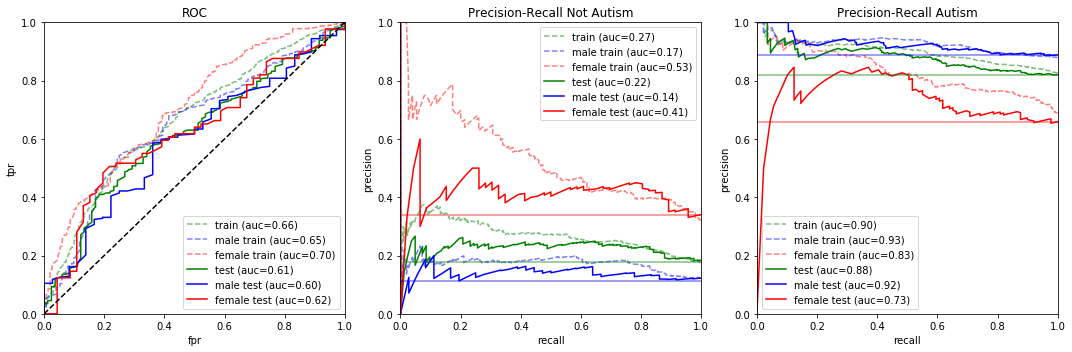

In [276]:
import matplotlib.pyplot as plt
from sklearn import metrics

plt.figure(figsize=(15, 5))
pos_label = 0

p = model.predict_proba(X[train_indices, :])
plt.subplot(1, 3, 1)
fpr, tpr, thresholds = metrics.roc_curve(y[train_indices], p[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='green')
plt.subplot(1, 3, 2)
precision, recall, thresholds = metrics.precision_recall_curve(y[train_indices], p[:, 0], pos_label=0)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='green')
plt.subplot(1, 3, 3)
precision, recall, thresholds = metrics.precision_recall_curve(y[train_indices], p[:, 1], pos_label=1)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='green')

p = model.predict_proba(X[male_train_indices, :])
plt.subplot(1, 3, 1)
fpr, tpr, thresholds = metrics.roc_curve(y[male_train_indices], p[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='male train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='blue')
plt.subplot(1, 3, 2)
precision, recall, thresholds = metrics.precision_recall_curve(y[male_train_indices], p[:, 0], pos_label=0)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='male train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='blue')
plt.subplot(1, 3, 3)
precision, recall, thresholds = metrics.precision_recall_curve(y[male_train_indices], p[:, 1], pos_label=1)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='male train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='blue')

p = model.predict_proba(X[female_train_indices, :])
plt.subplot(1, 3, 1)
fpr, tpr, thresholds = metrics.roc_curve(y[female_train_indices], p[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='female train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='red')
plt.subplot(1, 3, 2)
precision, recall, thresholds = metrics.precision_recall_curve(y[female_train_indices], p[:, 0], pos_label=0)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='female train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='red')
plt.subplot(1, 3, 3)
precision, recall, thresholds = metrics.precision_recall_curve(y[female_train_indices], p[:, 1], pos_label=1)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='female train (auc=%0.2f)' % auc, linestyle='--', alpha=0.5, color='red')

p = model.predict_proba(X[test_indices, :])
plt.subplot(1, 3, 1)
fpr, tpr, thresholds = metrics.roc_curve(y[test_indices], p[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='test (auc=%0.2f)' % auc, color='green')
plt.subplot(1, 3, 2)
precision, recall, thresholds = metrics.precision_recall_curve(y[test_indices], p[:, 0], pos_label=0)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='test (auc=%0.2f)' % auc, color='green')
plt.subplot(1, 3, 3)
precision, recall, thresholds = metrics.precision_recall_curve(y[test_indices], p[:, 1], pos_label=1)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='test (auc=%0.2f)' % auc, color='green')

p = model.predict_proba(X[male_test_indices, :])
plt.subplot(1, 3, 1)
fpr, tpr, thresholds = metrics.roc_curve(y[male_test_indices], p[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='male test (auc=%0.2f)' % auc, color='blue')
plt.subplot(1, 3, 2)
precision, recall, thresholds = metrics.precision_recall_curve(y[male_test_indices], p[:, 0], pos_label=0)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='male test (auc=%0.2f)' % auc, color='blue')
plt.subplot(1, 3, 3)
precision, recall, thresholds = metrics.precision_recall_curve(y[male_test_indices], p[:, 1], pos_label=1)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='male test (auc=%0.2f)' % auc, color='blue')

p = model.predict_proba(X[female_test_indices, :])
plt.subplot(1, 3, 1)
fpr, tpr, thresholds = metrics.roc_curve(y[female_test_indices], p[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='female test (auc=%0.2f)' % auc, color='red')
plt.subplot(1, 3, 2)
precision, recall, thresholds = metrics.precision_recall_curve(y[female_test_indices], p[:, 0], pos_label=0)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='female test (auc=%0.2f)' % auc, color='red')
plt.subplot(1, 3, 3)
precision, recall, thresholds = metrics.precision_recall_curve(y[female_test_indices], p[:, 1], pos_label=1)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label='female test (auc=%0.2f)' % auc, color='red')

plt.subplot(1, 3, 1)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.subplot(1, 3, 2)
plt.axhline(y=np.sum(y[test_indices]==0)/len(test_indices), color='green', linestyle='-', alpha=0.5)
plt.axhline(y=np.sum(y[female_test_indices]==0)/len(female_test_indices), color='red', linestyle='-', alpha=0.5)
plt.axhline(y=np.sum(y[male_test_indices]==0)/len(male_test_indices), color='blue', linestyle='-', alpha=0.5)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall Not Autism')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.subplot(1, 3, 3)
plt.axhline(y=np.sum(y[test_indices]==1)/len(test_indices), color='green', linestyle='-', alpha=0.5)
plt.axhline(y=np.sum(y[female_test_indices]==1)/len(female_test_indices), color='red', linestyle='-', alpha=0.5)
plt.axhline(y=np.sum(y[male_test_indices]==1)/len(male_test_indices), color='blue', linestyle='-', alpha=0.5)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall Autism')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.tight_layout()
plt.show()

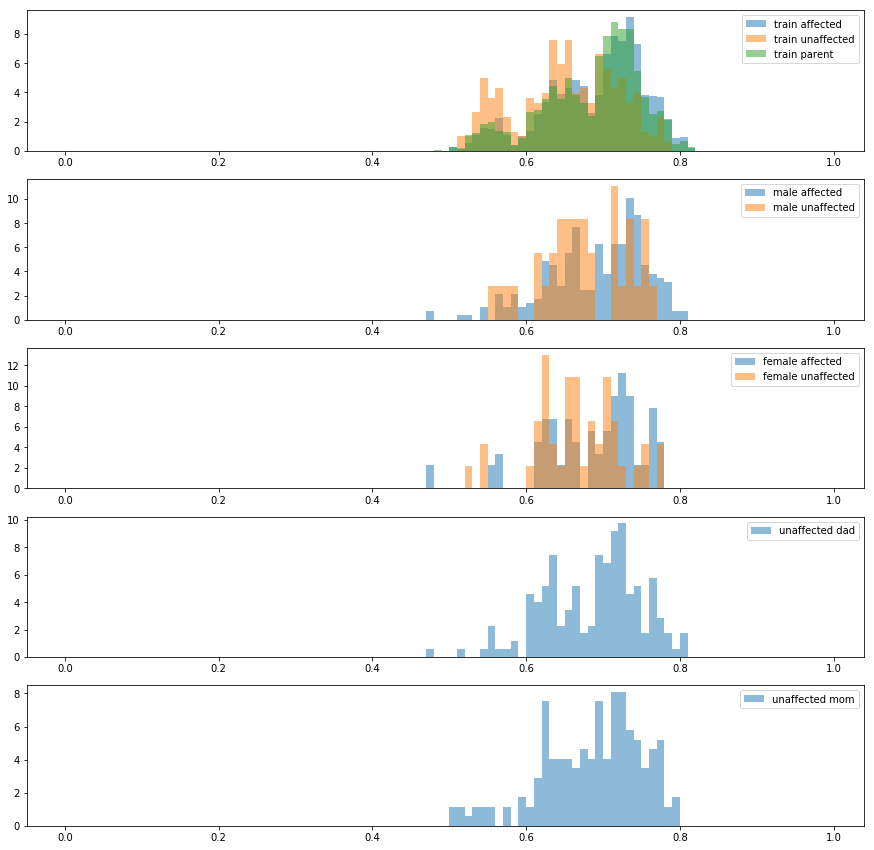

In [277]:
proba = model.predict_proba(X)[:, 1]

bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(15, 15))

#plt.hist(proba[[i for i in test_indices+parent_test_indices if y[i] == 1]], alpha=0.5, label='affected')
#plt.hist(proba[[i for i in test_indices+parent_test_indices if y[i] == 0]], alpha=0.5, label='unaffected')

#plt.hist(proba[[i for i in test_indices if y[i] == 1]], alpha=0.5, label='affected children', bins=bins)
#plt.hist(proba[[i for i in test_indices if y[i] == 0]], alpha=0.5, label='unaffected children', bins=bins)

plt.subplot(5, 1, 1)
plt.hist(proba[[i for i in train_indices if y[i] == 1]], alpha=0.5, label='train affected', bins=bins, density=True)
plt.hist(proba[[i for i in train_indices if y[i] == 0]], alpha=0.5, label='train unaffected', bins=bins, density=True)
plt.hist(proba[[i for i in parent_train_indices if y[i] == 0]], alpha=0.5, label='train parent', bins=bins, density=True)
plt.legend()

plt.subplot(5, 1, 2)
plt.hist(proba[[i for i in male_test_indices if y[i] == 1]], alpha=0.5, label='male affected', bins=bins, density=True)
plt.hist(proba[[i for i in male_test_indices if y[i] == 0]], alpha=0.5, label='male unaffected', bins=bins, density=True)
plt.legend()

plt.subplot(5, 1, 3)
plt.hist(proba[[i for i in female_test_indices if y[i] == 1]], alpha=0.5, label='female affected', bins=bins, density=True)
plt.hist(proba[[i for i in female_test_indices if y[i] == 0]], alpha=0.5, label='female unaffected', bins=bins, density=True)
plt.legend()

plt.subplot(5, 1, 4)
#plt.hist(proba[[i for i in dad_test_indices if y[i] == 1]], alpha=0.5, label='affected dad', bins=bins, density=True)
plt.hist(proba[[i for i in dad_test_indices if y[i] == 0]], alpha=0.5, label='unaffected dad', bins=bins, density=True)
plt.legend()

plt.subplot(5, 1, 5)
#plt.hist(proba[[i for i in mom_test_indices if y[i] == 1]], alpha=0.5, label='affected mom', bins=bins, density=True)
plt.hist(proba[[i for i in mom_test_indices if y[i] == 0]], alpha=0.5, label='unaffected mom', bins=bins, density=True)
plt.legend()
plt.show()

35


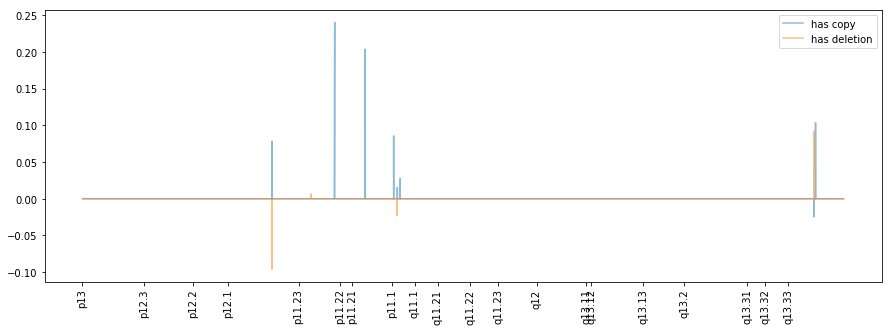

In [278]:
print(np.sum(model.coef_[0] != 0))
nonzero_indices = np.where(model.coef_[0] != 0)
#print(list(zip(snp_positions[nonzero_indices, :], model.coef_[0][nonzero_indices])))
plt.figure(figsize=(15, 5))
plt.plot(snp_positions[:, 0], model.coef_[0][:n], alpha=0.5, label='has copy')
plt.plot(snp_positions[:, 0], model.coef_[0][n:], alpha=0.5, label='has deletion')
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()
plt.show()

In [133]:
print(snp_positions[np.where(model.coef_[0][:n] != 0)[0]])
print(snp_positions[np.where(model.coef_[0][n:] != 0)[0]])

[[18686392. 18686377.]
 [18700632. 18700632.]
 [18700741. 18700632.]
 [18700741. 18700741.]
 [18700782. 18700741.]
 [18701131. 18701131.]
 [18701517. 18701131.]
 [18708862. 18708862.]
 [18708890. 18708862.]
 [20445214. 20445214.]
 [20445249. 20445214.]
 [20688719. 20688713.]
 [20688719. 20688719.]
 [20688721. 20688721.]
 [20688734. 20688721.]
 [20688736. 20688736.]
 [20688790. 20688783.]
 [21475454. 21475454.]
 [21475474. 21475460.]
 [21519119. 21519119.]
 [21519178. 21519119.]
 [21519819. 21519819.]
 [21519824. 21519824.]
 [21519840. 21519824.]
 [21520103. 21520103.]]
[[16982506. 16982500.]
 [16982674. 16982674.]
 [16982733. 16982674.]
 [16982733. 16982733.]
 [16982756. 16982756.]
 [16982758. 16982758.]
 [16982773. 16982758.]
 [16982773. 16982773.]
 [16982880. 16982860.]
 [16982880. 16982880.]
 [16983014. 16983020.]
 [16983138. 16983138.]
 [16983256. 16983256.]
 [16983344. 16983344.]
 [16983396. 16985012.]
 [16986605. 16985012.]
 [18716784. 18716784.]
 [18716796. 18716784.]
 [18716796

25051 (50101,)


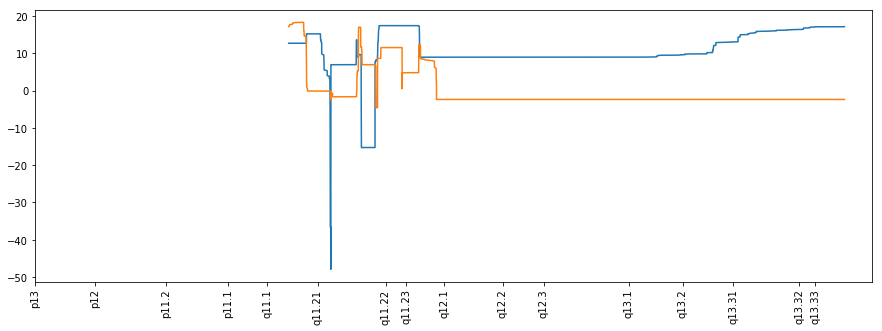

In [100]:
print(n, model.coef_[0].shape)
w = np.zeros((2*n,))
w[0] = np.asarray([-x for x in reversed(range(1, 2*n))]).dot(model.coef_[0])
for i in range(1, 2*n):
    w[i] = w[i-1]+n*model.coef_[0][i-1]
    
plt.figure(figsize=(15, 5))
plt.plot(snp_positions[:, 0], w[:n])
plt.plot(snp_positions[:, 0], w[n:])
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.show()

32541086 32543107


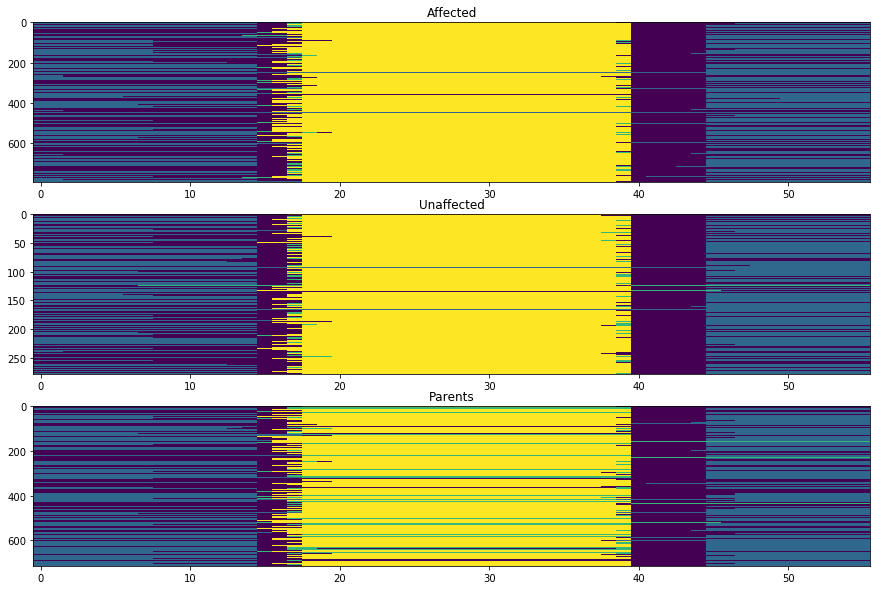

In [591]:
plt.figure(figsize=(15, 10))

start_index, end_index = pos_to_index[32541877]-20, pos_to_index[32542273]+20
print(snp_positions[start_index], snp_positions[end_index])
#start_index, end_index = pos_to_index[16983325]-200, pos_to_index[16985012]+50
plt.subplot(3, 1, 1)
plt.imshow(deletions[affected_indices, start_index:end_index], aspect='auto', vmax=2, vmin=-1)
plt.title('Affected')
plt.subplot(3, 1, 2)
plt.imshow(deletions[unaffected_indices, start_index:end_index], aspect='auto', vmax=2, vmin=-1)
plt.title('Unaffected')
plt.subplot(3, 1, 3)
plt.imshow(deletions[mother_indices+father_indices, start_index:end_index], aspect='auto', vmax=2, vmin=-1)
plt.title('Parents')
plt.show()

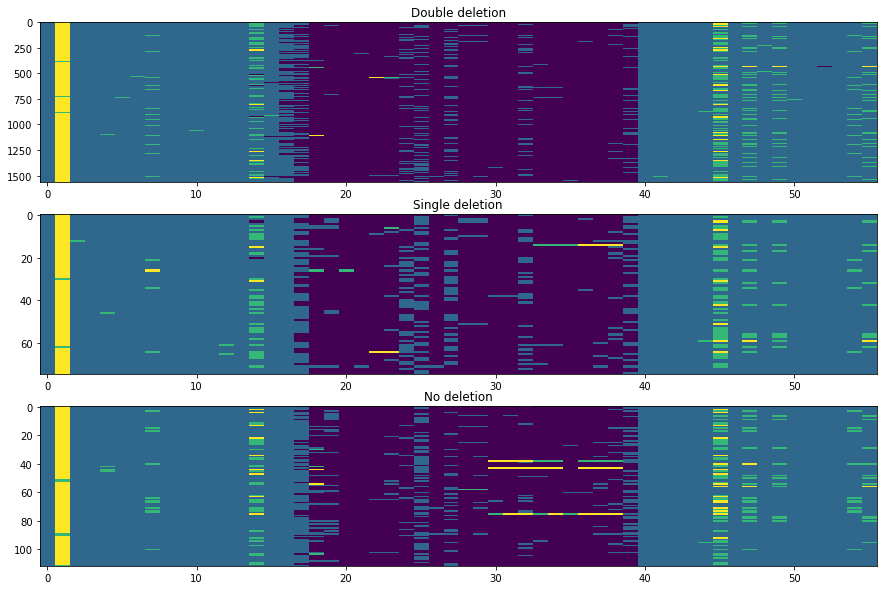

In [602]:
plt.figure(figsize=(15, 10))

c = whole_chrom[:, start_index:end_index].A

plt.subplot(3, 1, 1)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] == 2, axis=1)>20, :], aspect='auto', vmin=-1, vmax=2)
plt.title('Double deletion')

plt.subplot(3, 1, 2)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] == 1, axis=1)>20, :], aspect='auto', vmin=-1, vmax=2)
plt.title('Single deletion')

plt.subplot(3, 1, 3)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] > 0, axis=1)<=20, :], aspect='auto', vmin=-1, vmax=2)
plt.title('No deletion')

plt.show()

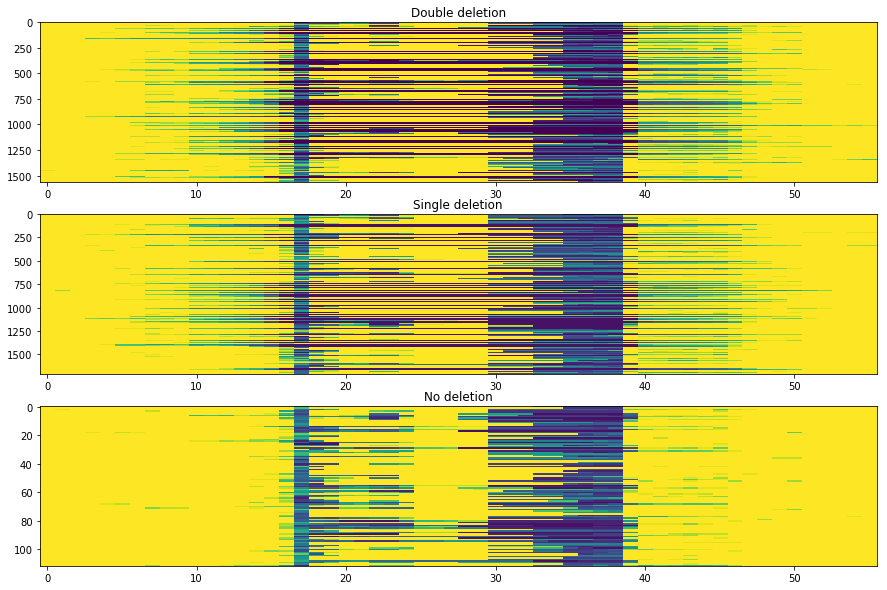

In [606]:
plt.figure(figsize=(15, 10))

c = whole_chrom_dp[:, start_index:end_index].A
max_value = np.max(c)
c[c==0] = max_value+1

#print(max_value)
#print(np.min(whole_chrom_dp[:, start_index:end_index].A))

plt.subplot(3, 1, 1)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] == 2, axis=1)>20, :], aspect='auto', vmin=1, vmax=max_value)
plt.title('Double deletion')

plt.subplot(3, 1, 2)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] == 1, axis=1)<=20, :], aspect='auto', vmin=0, vmax=max_value)
plt.title('Single deletion')

plt.subplot(3, 1, 3)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] > 0, axis=1)<=20, :], aspect='auto', vmin=0, vmax=max_value)
plt.title('No deletion')

plt.show()

In [344]:
print(snp_positions[start_index+15], snp_positions[start_index+45])

32541484 32542834


In [345]:
plt.plot()

[]

In [601]:
from scipy import sparse
from os import listdir

sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)

# pull families with sequence data
with open(sample_file, 'r') as f:
    gen_sample_ids = [line.strip() for line in f]
gen_sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(gen_sample_ids)])
gen_indices = [gen_sample_id_to_index[x] for x in sample_ids]

gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])

# pull genotype data from .npz
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[gen_indices, :] for gen_file in gen_files])
whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print('chrom shape only SNPs', m, n)

chrom shape only SNPs 1785 1003938


In [604]:
dp_data_dir = '../split_dp'
dp_files = sorted([f for f in listdir(dp_data_dir) if ('chr.%s' % chrom) in f and 'dp.npz' in f])

# pull genotype data from .npz
whole_chrom_dp = sparse.hstack([sparse.load_npz('%s/%s' % (dp_data_dir, dp_file))[gen_indices, :] for dp_file in dp_files])
whole_chrom_dp = whole_chrom_dp[:, snp_indices]
m, n = whole_chrom.shape
print('chrom dp shape only SNPs', m, n)

chrom dp shape only SNPs 1785 1003938


In [596]:
import gzip

start_pos, end_pos = 32541086, 32543107

# pull snp indices and positions
variant_file = '%s/chr.%s.gen.variants.txt.gz' % (data_dir, chrom)
indices_of_interest = []
is_del = []
lines = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if (int(pieces[1]) >= start_pos and int(pieces[1]) <= end_pos) and not (len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.'):
            indices_of_interest.append(i)
            is_del.append(len(pieces[3]) > len(pieces[4]))
            lines.append(line)
            print(line)

22	32541167	.	G	GT	98070.97	PASS	AC=241;AF=0.026;AN=9220;BaseQRankSum=-2.000e-02;DP=163578;FS=0.000;GC=19.05;GQ_MEAN=107.22;GQ_STDDEV=61.75;InbreedingCoeff=0.0243;MLEAC=241;MLEAF=0.026;MQ=60.24;MQ0=0;MQRankSum=-3.300e-02;NCC=0;NDA=2;POSITIVE_TRAIN_SITE;QD=12.08;RPA=6,7;RU=T;ReadPosRankSum=-6.900e-02;SOR=0.677;STR;VQSLOD=6.57;VariantType=INSERTION.NumRepetitions_6.EventLength_1.RepeatExpansion_T;culprit=SOR;cytoBand=22q12.3;Func=intergenic;Gene=RP1-127L4.7,C22orf42;GeneDetail=1908,dist=3826;1000g2015aug_all=0.0451278;CSQ=T|downstream_gene_variant|MODIFIER|C22orf42|ENSG00000205856|Transcript|ENST00000382097|protein_coding||||||||||rs113974257|3825|-1|insertion|HGNC|27160|YES|||CCDS33639.1|ENSP00000371529|CV042_HUMAN||UPI00003765B0||||||T:0.0451|T:0.1157|T:0.0245|T:0.005|T:0.0278|T:0.0235|||||||||||||||||||||||	GT:AD:DP:GQ:PL

22	32541546	.	ATATATAATATAATTTATTATATTATATAATGATATAT	A	1510.73	PASS	AC=7;AF=9.584e-04;AN=7304;BaseQRankSum=-6.600e-01;DP=76579;FS=3.074;GC=4.76;GQ_MEAN=41.73;GQ_STD

In [597]:
chrom_interest = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[:, indices_of_interest] for gen_file in gen_files])


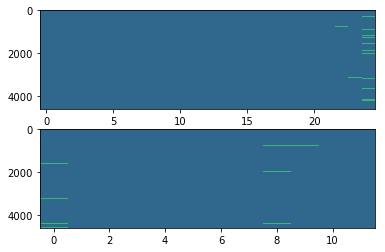

In [598]:
plt.subplot(2, 1, 1)
plt.imshow(chrom_interest.A[:, is_del]>0, aspect='auto', vmax=2, vmin=-1)
plt.subplot(2, 1, 2)
plt.imshow(chrom_interest.A[:, ~np.asarray(is_del)]>0, aspect='auto', vmax=2, vmin=-1)

plt.show()

21
0


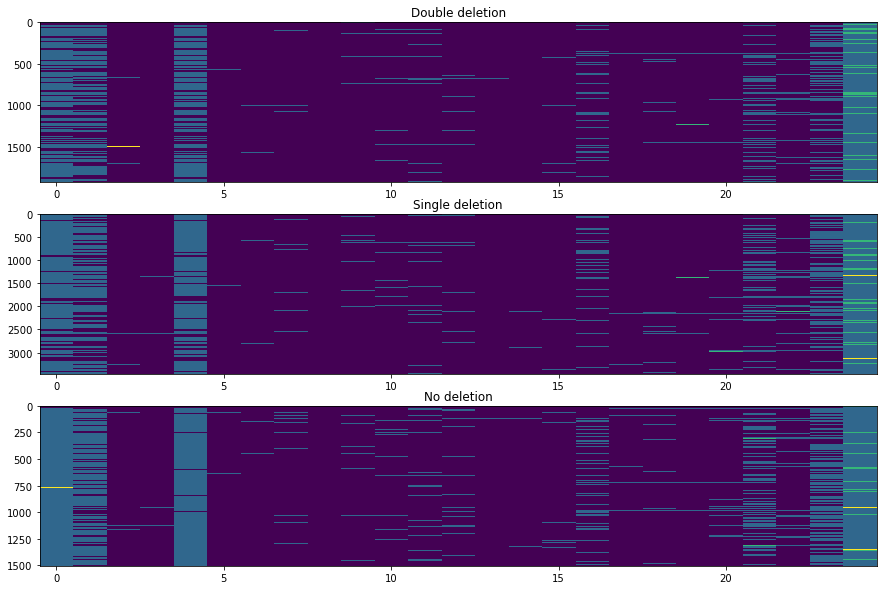

In [495]:
plt.figure(figsize=(15, 10))

c = chrom_interest.A[:, is_del]

print(max_value)
print(np.min(whole_chrom_dp[:, start_index:end_index].A))

plt.subplot(3, 1, 1)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] == 2, axis=1)>20, :], aspect='auto', vmin=-1, vmax=2)
plt.title('Double deletion')

plt.subplot(3, 1, 2)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] == 1, axis=1)<=20, :], aspect='auto', vmin=-1, vmax=2)
plt.title('Single deletion')

plt.subplot(3, 1, 3)
plt.imshow(c[np.sum(deletions[:, start_index:end_index] > 0, axis=1)<=20, :], aspect='auto', vmin=-1, vmax=2)
plt.title('No deletion')

plt.show()

22	32541819	.	AACT	A	45.53	VQSRTrancheINDEL99.00to99.90	AC=3;AF=5.690e-04;AN=5272;BaseQRankSum=0.804;DP=305329;FS=0.000;GC=4.76;GQ_MEAN=85.99;GQ_STDDEV=42.66;InbreedingCoeff=-0.0061;MLEAC=3;MLEAF=5.690e-04;MQ=60.00;MQ0=0;MQRankSum=0.804;NCC=1974;NDA=1;NEGATIVE_TRAIN_SITE;QD=15.18;ReadPosRankSum=0.804;SOR=0.693;VQSLOD=-2.401e+00;VariantType=DELETION.NumRepetitions_1.EventLength_3;culprit=DP;cytoBand=22q12.3;Func=intergenic;Gene=RP1-127L4.7,C22orf42;GeneDetail=2561,dist=3171;CSQ=-|downstream_gene_variant|MODIFIER|C22orf42|ENSG00000205856|Transcript|ENST00000382097|protein_coding|||||||||||3171|-1|deletion|HGNC|27160|YES|||CCDS33639.1|ENSP00000371529|CV042_HUMAN||UPI00003765B0||||||||||||||||||||||||||||||||||	GT:AD:DP:GQ:PGT:PID:PL

19 20


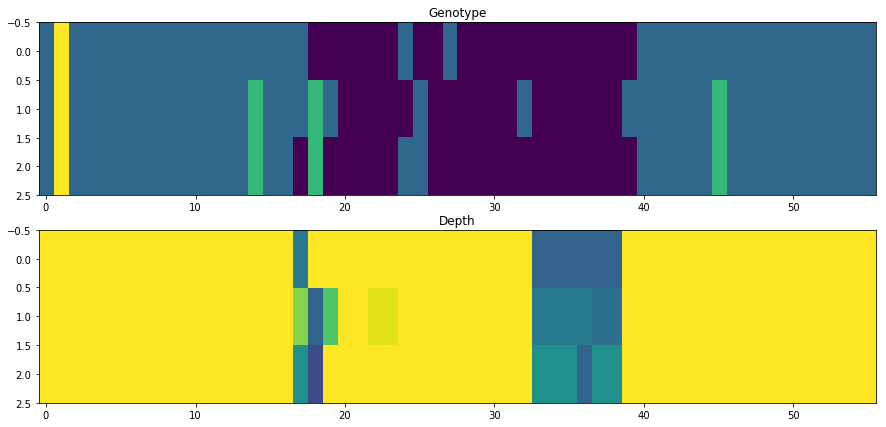

In [528]:
plt.figure(figsize=(15, 7))

index = np.where(is_del)[0][1]
line = lines[index]
print(line)
pieces = line.strip().split('\t')
del_start, del_end = int(pieces[1]), int(pieces[1]) + len(pieces[3]) - len(pieces[4])
index_start = np.where(snp_positions<=del_start)[0][-1] - start_index
index_end = np.where(snp_positions>=del_end)[0][0] - start_index
print(index_start, index_end)

c = whole_chrom[:, start_index:end_index].A

plt.subplot(2, 1, 1)
plt.imshow(c[chrom_interest.A[:, index]>0, :], aspect='auto', vmin=-1, vmax=2)
plt.title('Genotype')

c = whole_chrom_dp[:, start_index:end_index].A
max_value = np.max(c)
c[c==0] = max_value+1

plt.subplot(2, 1, 2)
plt.imshow(c[chrom_interest.A[:, index]>0, :], aspect='auto', vmin=-1, vmax=max_value)
plt.title('Depth')

plt.show()

In [369]:
print(whole_chrom.shape)

(3565, 1003938)


In [407]:
import random

#sib_dist, par_dist, non_rel_dist = [], [], []
#concord_sib_dist, discord_sib_dist = [], []

for _ in range(50):
    child = sample_ids[random.choice(child_indices)]
    print(child)

    relatives = [k for k, v in individual_to_family.items() if v == individual_to_family[child] and k != child]
    parents = [r for r in relatives if r in father_ids or r in mother_ids]
    siblings = [r for r in relatives if r not in father_ids and r not in mother_ids]
    
    print(parents)
    print(siblings)
    
    #non_relatives = random.sample(sample_ids, len(relatives))
    #print(non_relatives)
    
    if len(parents) == 2:
        sd = [np.sum(whole_chrom[sample_id_to_index[child], :] != whole_chrom[sample_id_to_index[r], :]) for r in siblings]

        sib_dist.extend(sd)
        par_dist.extend([np.sum(whole_chrom[sample_id_to_index[child], :] != whole_chrom[sample_id_to_index[r], :]) for r in parents])
        #non_rel_dist.extend([np.sum(whole_chrom[sample_id_to_index[child], :] != whole_chrom[sample_id_to_index[r], :]) for r in non_relatives])

        for sib, dist in zip(siblings, sd):
            if child_id_to_affected[child] == child_id_to_affected[sib]:
                concord_sib_dist.append(dist)
            else:
                discord_sib_dist.append(dist)


AU3768302
['AU3768202', 'AU3768201']
['AU3768303', 'AU3768301']
AU1338302
['AU1338202', 'AU1338201']
['AU1338303', 'AU1338304']
AU1312303
['AU1312202', 'AU1312201']
['AU1312301', 'AU1312302']
AU024203
['AU024201', 'AU024202']
['AU024204']
AU0883302
['AU0883202', 'AU0883201']
['AU0883301', 'AU0883303']
AU0862302
['AU0862202', 'AU0862201']
['AU0862301', 'AU0862303']
AU077704
['AU077701', 'AU077702']
['AU077703', 'AU077705']
AU034003
['AU034001', 'AU034002']
['AU034004']
AU1321301
['AU1321202', 'AU1321201']
['AU1321303', 'AU1321302']
AU2073303
['AU2073202', 'AU2073201']
['AU2073301', 'AU2073302']
AU1159302
['AU1159202', 'AU1159201']
['AU1159301']
AU1285301
['AU1285202', 'AU1285201']
['AU1285302']
AU1772302
['AU1772202', 'AU1772201']
['AU1772301', 'AU1772303']
AU043003
['AU043001', 'AU043002']
['AU043004']
AU1835303
['AU1835202', 'AU1835201']
['AU1835302']
AU1779302
['AU1779202', 'AU1779201']
['AU1779301']
AU1456302
['AU1456202', 'AU1456201']
['AU1456303']
AU1076305
['AU1076202', 'AU107620

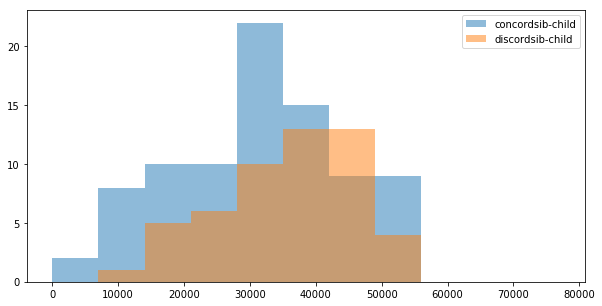

In [425]:
plt.figure(figsize=(10, 5))

#plt.hist(sib_dist, bins=range(0, 80000, 5000), alpha=0.5, label='sib-child')
#plt.hist(par_dist, bins=range(0, 80000, 5000), alpha=0.5, label='par-child')
#plt.hist(non_rel_dist, bins=range(0, 80000, 5000), alpha=0.5, label='norel-child')
plt.hist(concord_sib_dist, bins=range(0, 80000, 7000), alpha=0.5, label='concordsib-child')
plt.hist(discord_sib_dist, bins=range(0, 80000, 7000), alpha=0.5, label='discordsib-child')

plt.legend()
plt.show()

In [418]:
from scipy.stats import ttest_ind

print(ttest_ind(concord_sib_dist, discord_sib_dist))
print(ttest_ind(concord_sib_dist, discord_sib_dist, equal_var=False))

Ttest_indResult(statistic=-2.2153499139269672, pvalue=0.028411814277617527)
Ttest_indResult(statistic=-2.3418156432385961, pvalue=0.020757433160315936)


In [422]:
import random

sib_dist2, par_dist2, non_rel_dist2 = [], [], []
concord_sib_dist2, discord_sib_dist2 = [], []

for _ in range(50):
    child = sample_ids[random.choice(child_indices)]
    print(child)

    relatives = [k for k, v in individual_to_family.items() if v == individual_to_family[child] and k != child]
    parents = [r for r in relatives if r in father_ids or r in mother_ids]
    siblings = [r for r in relatives if r not in father_ids and r not in mother_ids]
    
    print(parents)
    print(siblings)
    
    #non_relatives = random.sample(sample_ids, len(relatives))
    #print(non_relatives)
    
    if len(parents) == 2:
        sd = [np.sum((whole_chrom[sample_id_to_index[child], :] > 0) != (whole_chrom[sample_id_to_index[r], :] > 0)) for r in siblings]

        sib_dist2.extend(sd)
        par_dist2.extend([np.sum((whole_chrom[sample_id_to_index[child], :]>0) != (whole_chrom[sample_id_to_index[r], :]>0)) for r in parents])
        #non_rel_dist2.extend([np.sum(whole_chrom[sample_id_to_index[child], :] != whole_chrom[sample_id_to_index[r], :]) for r in non_relatives])

        for sib, dist in zip(siblings, sd):
            if child_id_to_affected[child] == child_id_to_affected[sib]:
                concord_sib_dist2.append(dist)
            else:
                discord_sib_dist2.append(dist)


AU3402301
['AU3402202', 'AU3402201']
['AU3402302', 'AU3402303']
AU1993302
['AU1993202', 'AU1993201']
['AU1993301']
AU0955302
['AU0955202', 'AU0955201']
['AU0955303', 'AU0955301']
AU1947301
['AU1947202', 'AU1947201']
['AU1947302', 'AU1947303']
AU1228304
['AU1228202', 'AU1228201']
['AU1228303']
AU1394302
['AU1394202', 'AU1394201']
['AU1394301', 'AU1394303']
AU1694301
['AU1694202', 'AU1694201']
['AU1694302']
AU1218303
['AU1218202', 'AU1218201']
['AU1218301', 'AU1218302']
AU2157301
['AU2157202', 'AU2157201']
['AU2157302']
AU012703
['AU012701', 'AU012702']
['AU012705', 'AU012704']
AU1388302
['AU1388202', 'AU1388201']
['AU1388301']
AU1589302
['AU1589202', 'AU1589201']
['AU1589301']
AU1579302
['AU1579202', 'AU1579201']
['AU1579303', 'AU1579301']
AU1720311
['AU1720212', 'AU1720211']
['AU1720312']
AU1921311
['AU1921211']
[]
AU1916302
['AU1916202', 'AU1916201']
['AU1916303', 'AU1916301']
AU1299301
['AU1299202', 'AU1299201']
['AU1299302']
AU1213302
['AU1213202', 'AU1213201']
['AU1213303']
AU37873

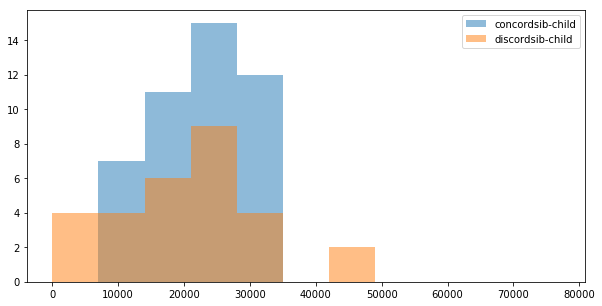

In [423]:
plt.figure(figsize=(10, 5))

#plt.hist(sib_dist, bins=range(0, 80000, 5000), alpha=0.5)
#plt.hist(par_dist, bins=range(0, 80000, 5000), alpha=0.5, label='par-child')
#plt.hist(non_rel_dist, bins=range(0, 80000, 5000), alpha=0.5, label='norel-child')
plt.hist(concord_sib_dist2, bins=range(0, 80000, 7000), alpha=0.5, label='concordsib-child')
plt.hist(discord_sib_dist2, bins=range(0, 80000, 7000), alpha=0.5, label='discordsib-child')

plt.legend()
plt.show()